In [1]:
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import datetime
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import STL
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import statsmodels.api as sm

In [2]:
import warnings
warnings.filterwarnings('ignore')

In [3]:
# Download data
start_date = '2000-01-01'
end_date = '2009-12-31'
sp500_data = yf.download('^GSPC', start=start_date, end=end_date, interval='1mo')
sp500_data.columns = sp500_data.columns.get_level_values(0)

# Compute log returns
sp500_data = sp500_data[['Close']].dropna()
sp500_data['Log Return'] = np.log(sp500_data['Close'] / sp500_data['Close'].shift(1))
sp500_data.dropna(inplace=True)

# Add month column for grouping
sp500_data['Month'] = sp500_data.index.month

# Detect outliers using 3-sigma rule
mean = sp500_data['Log Return'].mean()
std = sp500_data['Log Return'].std()
threshold = 3
outliers = np.abs(sp500_data['Log Return'] - mean) > threshold * std

# Monthly average returns
monthly_avg_returns = sp500_data.groupby('Month')['Log Return'].mean()

# Print outliers and replacement values
print("Outliers and their replacements:\n")
for idx in sp500_data[outliers].index:
    date = idx.strftime('%Y-%m')
    original = sp500_data.loc[idx, 'Log Return']
    month = sp500_data.loc[idx, 'Month']
    replacement = monthly_avg_returns.loc[month]
    print(f"{date}: original={original:.4f}, replacement={replacement:.4f}")

# Replace outliers with monthly average
def replace_with_monthly_avg(row):
    if outliers.loc[row.name]:
        return monthly_avg_returns.loc[row['Month']]
    return row['Log Return']

sp500_data['Log Return'] = sp500_data.apply(replace_with_monthly_avg, axis=1)

# Drop helper column
sp500_data.drop(columns=['Month'], inplace=True)

YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed

Outliers and their replacements:

2008-10: original=-0.1856, replacement=-0.0014


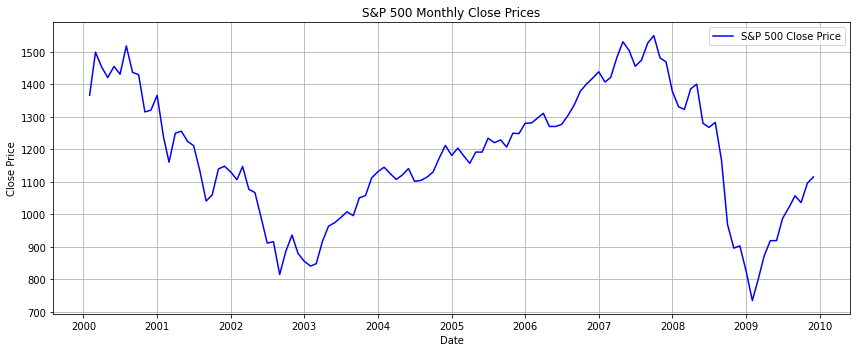

In [4]:
plt.figure(figsize=(12, 5))
plt.plot(sp500_data.index, sp500_data['Close'], label='S&P 500 Close Price', color='blue')
plt.title('S&P 500 Monthly Close Prices')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

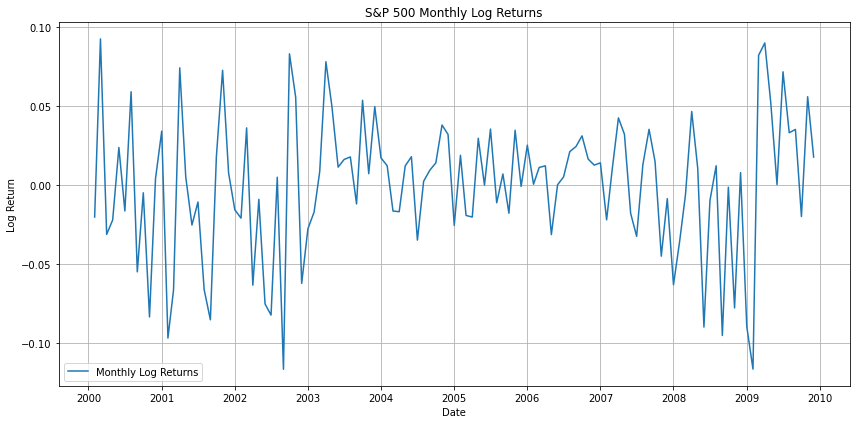

In [5]:
plt.figure(figsize=(12, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns')
plt.title('S&P 500 Monthly Log Returns')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

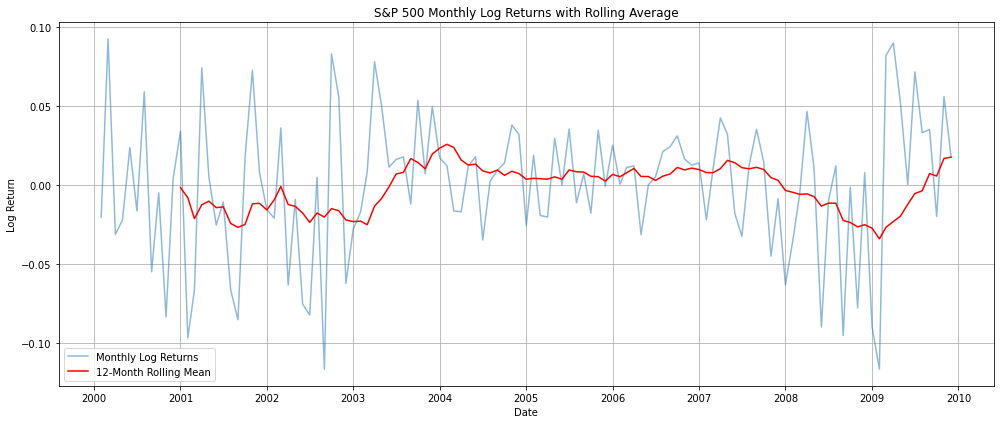

In [6]:
sp500_data['Rolling Mean'] = sp500_data['Log Return'].rolling(window=12).mean() 
#first 11 values are meant to be empty for rolling mean, don't get scared!
plt.figure(figsize=(14, 6))
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Monthly Log Returns', alpha=0.5)
plt.plot(sp500_data.index, sp500_data['Rolling Mean'], label='12-Month Rolling Mean', color='red')
plt.title('S&P 500 Monthly Log Returns with Rolling Average')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

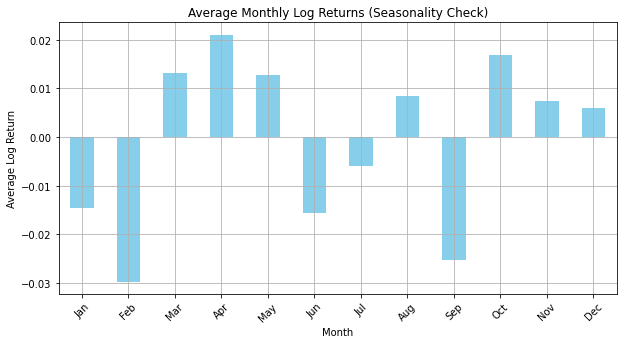

In [7]:
sp500_data['Month'] = sp500_data.index.month
monthly_avg = sp500_data.groupby('Month')['Log Return'].mean()

plt.figure(figsize=(10, 5))
monthly_avg.plot(kind='bar', color='skyblue')
plt.title('Average Monthly Log Returns (Seasonality Check)')
plt.xlabel('Month')
plt.ylabel('Average Log Return')
plt.xticks(ticks=range(0,12), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'], rotation=45)
plt.grid(True)
#plt.tight_layout()
plt.show()


<Figure size 864x432 with 0 Axes>

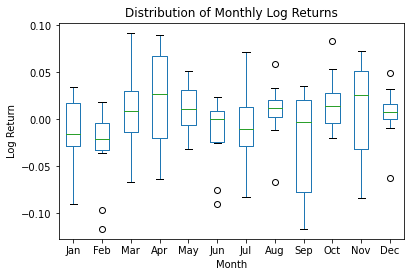

In [8]:
plt.figure(figsize=(12, 6))
sp500_data.boxplot(column='Log Return', by='Month', grid=False)
plt.title('Distribution of Monthly Log Returns')
plt.suptitle('')  # Hide default title
plt.xlabel('Month')
plt.ylabel('Log Return')
plt.xticks(ticks=range(1,13), labels=[
    'Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
    'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec'])
#plt.tight_layout()
plt.show()

In [9]:
# Week 2 work 

# ADF test on log returns

adf_result = adfuller(sp500_data['Log Return'])

print('ADF Statistic: %f' % adf_result[0])
print('p-value: %f' % adf_result[1])
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

ADF Statistic: -9.939269
p-value: 0.000000
Critical Values:
	1%: -3.4870216863700767
	5%: -2.8863625166643136
	10%: -2.580009026141913


**Analysis:**

The ADF statistic of -9.939, which is well below all critical values, and a p-value of 0.000 indicate strong evidence to reject the null hypothesis, confirming that the time series is stationary.

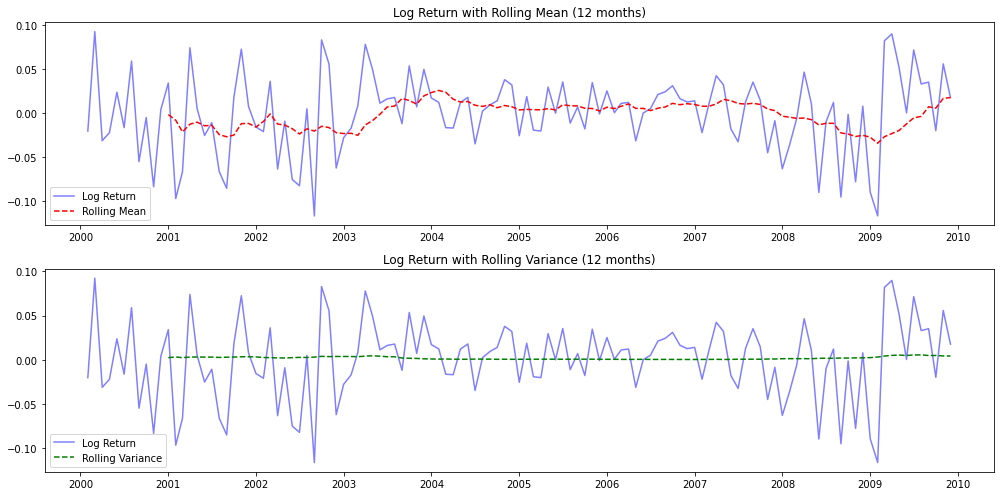

In [10]:
# rolling mean and rolling variance

window = 12

rolling_mean = sp500_data['Log Return'].rolling(window=window).mean()
rolling_variance = sp500_data['Log Return'].rolling(window=window).var()

plt.figure(figsize=(14, 7))

plt.subplot(2, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_mean, label='Rolling Mean', color='red', linestyle='--')
plt.title('Log Return with Rolling Mean (12 months)')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue', alpha=0.5)
plt.plot(rolling_variance, label='Rolling Variance', color='green', linestyle='--')
plt.title('Log Return with Rolling Variance (12 months)')
plt.legend()

plt.tight_layout()
plt.show()

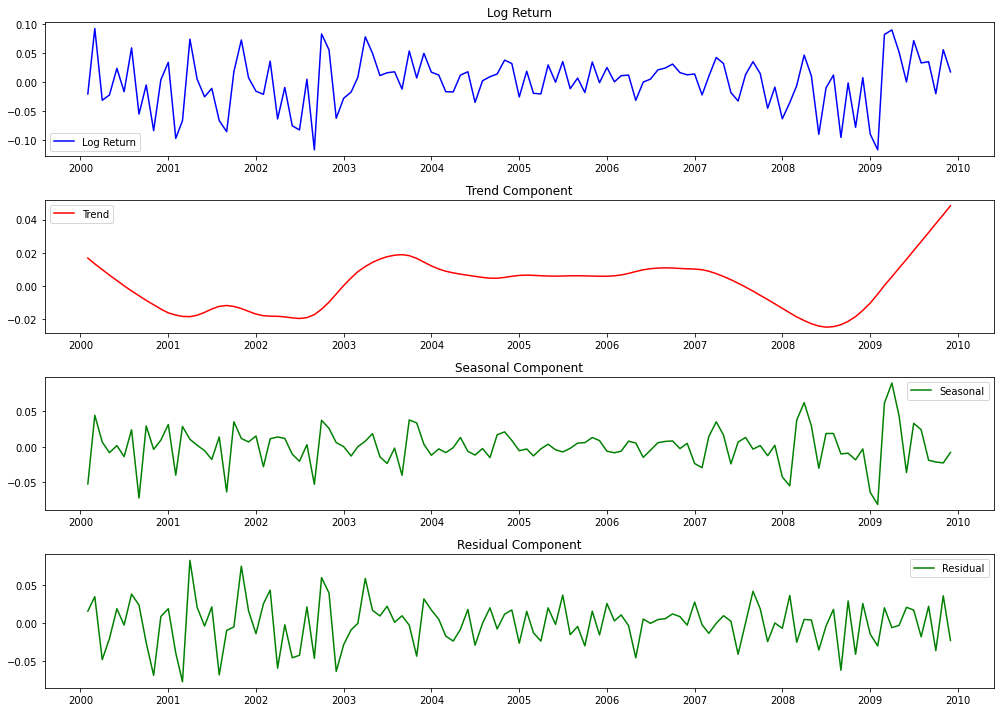

In [11]:
# perform STL decomposition on the log returns

stl = STL(sp500_data['Log Return'], period=12)
result = stl.fit()

seasonal = result.seasonal
trend = result.trend
residual = result.resid

plt.figure(figsize=(14, 10))

plt.subplot(4, 1, 1)
plt.plot(sp500_data.index, sp500_data['Log Return'], label='Log Return', color='blue')
plt.title('Log Return')
plt.legend()

plt.subplot(4, 1, 2)
plt.plot(sp500_data.index, trend, label='Trend', color='red')
plt.title('Trend Component')
plt.legend()

plt.subplot(4, 1, 3)
plt.plot(sp500_data.index, seasonal, label='Seasonal', color='green')
plt.title('Seasonal Component')
plt.legend()

plt.subplot(4, 1, 4)
plt.plot(sp500_data.index, residual, label='Residual', color='green')
plt.title('Residual Component')
plt.legend()

plt.tight_layout()
plt.show()

In [12]:
arima_model = ARIMA(sp500_data['Log Return'], order=(1, 0, 1))
arima_result = arima_model.fit()
print("ARIMA Model Summary:")
print(arima_result.summary())

ARIMA Model Summary:
                               SARIMAX Results                                
Dep. Variable:             Log Return   No. Observations:                  119
Model:                 ARIMA(1, 0, 1)   Log Likelihood                 204.604
Date:                Mon, 05 May 2025   AIC                           -401.207
Time:                        10:37:07   BIC                           -390.091
Sample:                    02-01-2000   HQIC                          -396.693
                         - 12-01-2009                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0004      0.004     -0.082      0.934      -0.009       0.008
ar.L1         -0.8360      0.134     -6.255      0.000      -1.098      -0.574
ma.L1          0.9329      0.09

**Analysis:**

* AR(1) term (ar.L1 = -0.8360, p < 0.001):
Indicates a strong and significant negative autocorrelation with the previous lag, suggesting mean-reverting behavior in the log returns.

* MA(1) term (ma.L1 = 0.9329, p < 0.001):
Significantly positive, showing a strong moving average component, which helps to correct for shocks in the previous period.

* Sigma² (σ² = 0.0019, p < 0.001):
The variance of the residuals is small and statistically significant, indicating a well-fitted model in terms of capturing volatility.

In [13]:
sarima_model = SARIMAX(sp500_data['Log Return'], order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit()
print("\nSARIMA Model Summary:")
print(sarima_result.summary())


 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f= -1.71303D+00    |proj g|=  1.85537D-01

At iterate    5    f= -1.71306D+00    |proj g|=  1.30840D-01

At iterate   10    f= -1.71322D+00    |proj g|=  1.16896D-02

At iterate   15    f= -1.71322D+00    |proj g|=  5.79374D-02

At iterate   20    f= -1.71426D+00    |proj g|=  7.25207D-01

At iterate   25    f= -1.71957D+00    |proj g|=  9.66608D-02

At iterate   30    f= -1.71962D+00    |proj g|=  6.44428D-02

At iterate   35    f= -1.72048D+00    |proj g|=  2.46604D-01

At iterate   40    f= -1.72069D+00    |proj g|=  1.06277D-03

At iterate   45    f= -1.72069D+00    |proj g|=  4.21813D-02

At iterate   50    f= -1.72084D+00    |proj g|=  9.54305D-02

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cau

**Analysis:**

* AR(1) term (ar.L1 = -0.8488, p < 0.001):Strong and statistically significant negative autocorrelation, indicating persistence and mean reversion in the series.

* MA(1) term (ma.L1 = 0.9393, p < 0.001): Significantly positive, capturing short-term shock effects effectively and improving model accuracy.

* Sigma² (σ² = 0.0019, p < 0.001): Small and significant variance of the residuals, suggesting the model explains the data well.

* The seasonal terms (ar.S.L12 and ma.S.L12) are not statistically significant (p > 0.8), indicating that seasonal components may not meaningfully improve the model.

In [14]:
# Ensure 'Month' column is category
sp500_data['Month'] = sp500_data.index.month.astype('category')

# Create dummy variables (January as baseline)
month_dummies = pd.get_dummies(sp500_data['Month'], drop_first=True)

# Regression setup
X = sm.add_constant(month_dummies)
y = sp500_data['Log Return']

reg_model = sm.OLS(y, X)
reg_result = reg_model.fit()

print("\nRegression Summary (Monthly Dummies):")
print(reg_result.summary())



Regression Summary (Monthly Dummies):
                            OLS Regression Results                            
Dep. Variable:             Log Return   R-squared:                       0.140
Model:                            OLS   Adj. R-squared:                  0.052
Method:                 Least Squares   F-statistic:                     1.583
Date:                Mon, 05 May 2025   Prob (F-statistic):              0.114
Time:                        10:39:59   Log-Likelihood:                 211.81
No. Observations:                 119   AIC:                            -399.6
Df Residuals:                     107   BIC:                            -366.3
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        

**Analysis:**

* No individual month coefficients are statistically significant at the 5% level (all p-values > 0.05), though:

* R-squared = 0.140, Adjusted R-squared = 0.052: Indicates that the model explains only a small portion of the variability in log returns, and adjusted R² suggests limited explanatory power once the number of predictors is accounted for.

* F-statistic p-value = 0.114: The overall model is not statistically significant, meaning the monthly dummies do not jointly explain the variation in log returns.



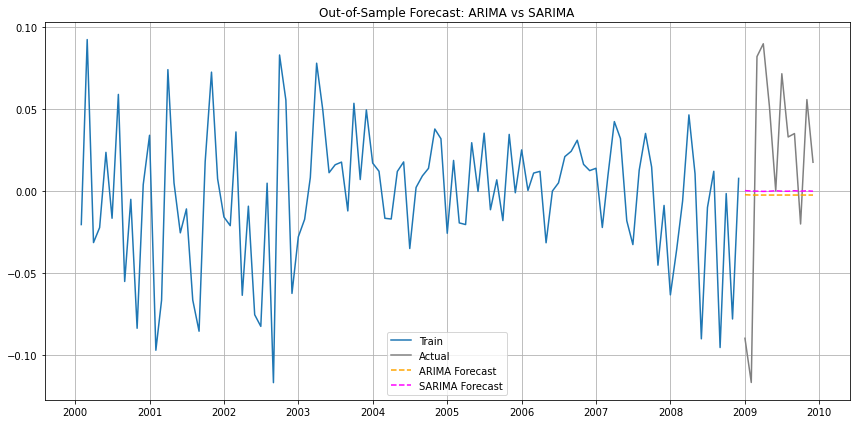

In [15]:
# week 4

# generate out of sample forecasts from ARIMA & SARIMA models

# split the data into testing and training 
train = sp500_data['Log Return'][:-12] 
test = sp500_data['Log Return'][-12:] # last 12 months

# fit ARIMA model w/ training data
arima_model = ARIMA(train, order=(1, 0, 1))
arima_result = arima_model.fit()

# forecast ARIMA
arima_forecast = arima_result.forecast(steps=12)

# fit SARIMA model
sarima_model = SARIMAX(train, order=(1, 0, 1), seasonal_order=(1, 0, 1, 12))
sarima_result = sarima_model.fit(disp=False)

# forecast SARIMA
sarima_forecast = sarima_result.forecast(steps=12)

# plot forecasts
plt.figure(figsize=(12, 6))
plt.plot(train.index, train, label='Train')
plt.plot(test.index, test, label='Actual', color='grey')
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', linestyle='--', color='orange')
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', linestyle='--', color='magenta')
plt.title('Out-of-Sample Forecast: ARIMA vs SARIMA')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

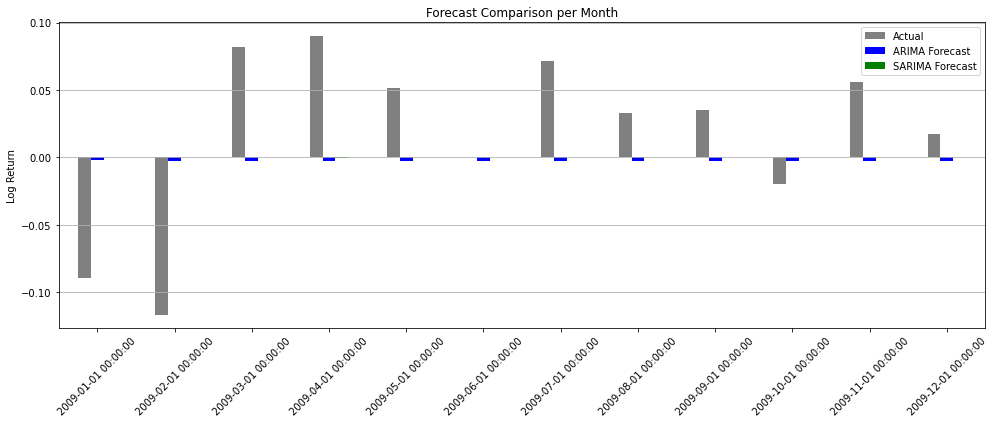

In [16]:
# plot monthly forecast comparisons

df_compare = pd.DataFrame({
    'Actual': test,
    'ARIMA Forecast': arima_forecast,
    'SARIMA Forecast': sarima_forecast
})

df_compare.plot(kind='bar', figsize=(14, 6), color=['grey', 'blue', 'green'])
plt.title('Forecast Comparison per Month')
plt.ylabel('Log Return')
plt.xticks(rotation=45)
plt.tight_layout()
plt.grid(axis='y')
plt.show()

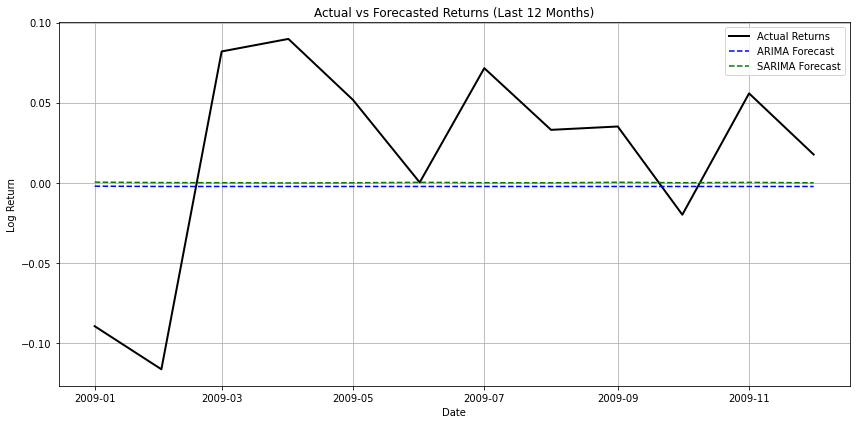

In [17]:
# actuals vs forecasted results plot

plt.figure(figsize=(12, 6))

# actual
plt.plot(test.index, test, label='Actual Returns', color='black', linewidth=2)

# ARIMA forecast
plt.plot(test.index, arima_forecast, label='ARIMA Forecast', color='blue', linestyle='--')

# SARIMA forecast
plt.plot(test.index, sarima_forecast, label='SARIMA Forecast', color='green', linestyle='--')

plt.title('Actual vs Forecasted Returns (Last 12 Months)')
plt.xlabel('Date')
plt.ylabel('Log Return')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [18]:
# evaluate forcasting accuracy using MAE and RMSE

# ARIMA accuracy
arima_mae = mean_absolute_error(test, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(test, arima_forecast))

# SARIMA accuracy
sarima_mae = mean_absolute_error(test, sarima_forecast)
sarima_rmse = np.sqrt(mean_squared_error(test, sarima_forecast))

print("Forecast Accuracy (last 12 months):")
print(f"ARIMA MAE: {arima_mae:.5f}")
print(f"ARIMA RMSE: {arima_rmse:.5f}")
print()
print(f"SARIMA MAE: {sarima_mae:.5f}")
print(f"SARIMA RMSE: {sarima_rmse:.5f}")

Forecast Accuracy (last 12 months):
ARIMA MAE: 0.05641
ARIMA RMSE: 0.06543

SARIMA MAE: 0.05522
SARIMA RMSE: 0.06478


**Analysis:**

The SARIMA model slightly outperforms the ARIMA model in forecast accuracy, with lower MAE (0.05522 vs. 0.05641) and RMSE (0.06478 vs. 0.06543) over the last 12 months.

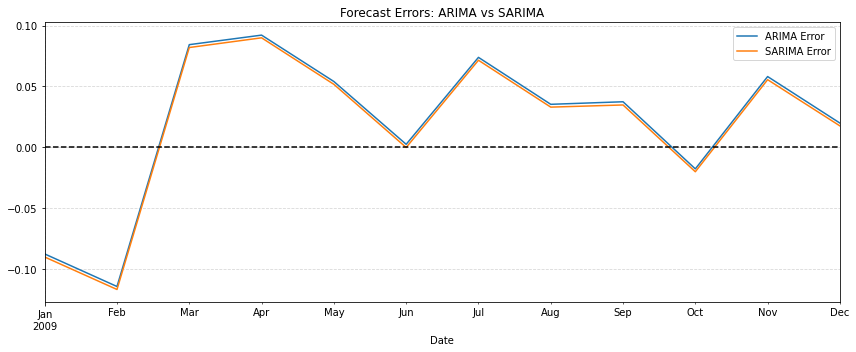

In [19]:
# plot forecast errors for ARIMA & SARIMA

errors = pd.DataFrame({
    'ARIMA Error': test - arima_forecast,
    'SARIMA Error': test - sarima_forecast
})

errors.plot(figsize=(12, 5), title='Forecast Errors: ARIMA vs SARIMA')
plt.axhline(0, color='black', linestyle='--')
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()